In [1]:
!git clone https://github.com/bowman-aikium/aikium_thermal_stability
%cd aikium_thermal_stability

fatal: destination path 'aikium_thermal_stability' already exists and is not an empty directory.
/content/aikium_thermal_stability


In [2]:
!pip install sympy==1.12
import sympy
print(sympy.__version__)

1.12


In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from google.colab import files



# Import from your Model folder
from Model.model import thermalMLP, ProteinTmDataset


In [4]:
embedding_np = np.load("/content/esm2_embeddings_with_ids.npz", allow_pickle=True)
dataset_df = pd.read_csv("/content/Stratified_data.csv")

embedding = embedding_np["embeddings"]   # shape: (N, hidden_dim)
ids = embedding_np["ids"]

emb_df = pd.DataFrame({
    "ID": ids,
    "embedding": list(embedding)
})

emb_df["ID"] = emb_df["ID"].astype(int)
dataset_df["ID"] = dataset_df["ID"].astype(int)
merged = emb_df.merge(dataset_df, on="ID")
merged




,ID,embedding,Tm,Sequence,From,AA_length,MW
0,117012,"[3.4952238, 2.9369724, -3.406106, -1.0034976, ...",45.556042,MKWAYKEENNFEKRRAEGDKIRRKYPDRIPVIVEKAPKSKLHDLDK...,meltome,123,14.763731
1,313786,"[2.2217994, -2.0552912, -0.14634663, 1.3754547...",43.863329,MVKATNVDLSLEDIISKTRKTTGSIQKKSFGGARRGNTRPTGLPRR...,meltome,240,25.695370
2,169171,"[3.0030677, 4.205013, 4.074065, 0.7811, -6.895...",43.574470,MPRANEIKKGMVLNYNGKLLLVKDIDIQSPTARGAATLYKMRFSDV...,meltome,190,21.532381
3,227821,"[4.7244706, -0.123155594, 1.057647, 4.5875287,...",40.496359,MTKSELIERMLTKQPQLSAKDVELAVKTILDHMSQSLSTGERIEIR...,meltome,96,10.757199
4,97927,"[2.16275, -1.2902148, 2.1692014, 0.009807652, ...",37.073883,MRQVVLDTETTGIGAEKGHRIIEIGCVELIDRKLTGRHYHQYVNPQ...,meltome,234,26.063256
...,...,...,...,...,...,...,...
23415,200713,"[3.211512, 0.9198779, -0.08337058, -1.2356853,...",86.289547,MTVRQVLVHKGGGVHAIHPEATVLDALRKLAEHDIGALLVMEGERL...,meltome,143,15.916415
23416,267005,"[-1.4136505, -2.4800174, 0.06798242, 2.689519,...",88.057949,MTGLELLAVALGMRHGVDPDHLAAVDGLSRVRPSPLNGVLFALGHG...,meltome,220,22.874996
23417,269836,"[2.5266905, -5.975683, -3.1002605, 1.2522675, ...",88.583454,MASLSFMIKEYNDYYIIDFERPVRKFSSAPFNGGVGTSLRYINRTV...,meltome,215,24.262483
23418,298355,"[0.30273947, 2.1589444, -0.4573475, -0.4192088...",86.755190,MRFKAELMNAPEMRRALYRIAHEIVEANKGTEGLALVGIHTRGIPL...,meltome,181,20.466363


In [5]:
def train_and_eval(params, input_dim, train_loader, val_loader):

    model = thermalMLP(
        input_dim=input_dim,
        hidden_sizes=params["hidden_sizes"],
        activation=params["activation"],
        dropout=params["dropout"]
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    train_losses = []
    val_losses = []

    for epoch in range(params["epochs"]):
        # ---- Training ----
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                epoch_val_loss += criterion(preds, yb).item()
        val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{params['epochs']} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [21]:
import itertools

# Define parameter grid
hidden_sizes_list = [
    [128],
    [512, 256],
    [1024, 512, 256]
]
dropout_list = [0.0, 0.2, 0.3]
lr_list = [1e-3, 5e-4]

# Build full grid
hyperparam_sweep = []
for hs, d, lr in itertools.product(hidden_sizes_list, dropout_list, lr_list):
    hyperparam_sweep.append({
        "hidden_sizes": hs,
        "activation": nn.ReLU,
        "dropout": d,
        "lr": lr,
        "epochs": 30
    })

print(f"Total configs: {len(hyperparam_sweep)}")

Total configs: 18


Epoch 1/30 | Train Loss: 124.8876 | Val Loss: 75.0728
Epoch 2/30 | Train Loss: 63.2118 | Val Loss: 56.9883
Epoch 3/30 | Train Loss: 50.5613 | Val Loss: 48.2255
Epoch 4/30 | Train Loss: 42.1775 | Val Loss: 41.5689
Epoch 5/30 | Train Loss: 36.0514 | Val Loss: 37.7226
Epoch 6/30 | Train Loss: 32.1109 | Val Loss: 36.6809
Epoch 7/30 | Train Loss: 28.5862 | Val Loss: 31.1964
Epoch 8/30 | Train Loss: 26.5333 | Val Loss: 30.4106
Epoch 9/30 | Train Loss: 23.7605 | Val Loss: 28.3568
Epoch 10/30 | Train Loss: 22.4186 | Val Loss: 27.5315
Epoch 11/30 | Train Loss: 20.7601 | Val Loss: 23.1827
Epoch 12/30 | Train Loss: 19.4258 | Val Loss: 23.2866
Epoch 13/30 | Train Loss: 17.8430 | Val Loss: 21.3819
Epoch 14/30 | Train Loss: 16.8891 | Val Loss: 20.2583
Epoch 15/30 | Train Loss: 16.4232 | Val Loss: 23.2746
Epoch 16/30 | Train Loss: 14.9028 | Val Loss: 20.6438
Epoch 17/30 | Train Loss: 14.7366 | Val Loss: 20.0685
Epoch 18/30 | Train Loss: 13.7783 | Val Loss: 18.1701
Epoch 19/30 | Train Loss: 13.5394 | 

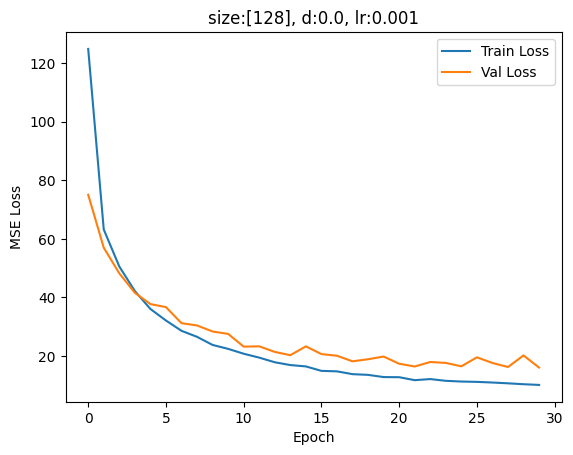

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 159.1913 | Val Loss: 77.8316
Epoch 2/30 | Train Loss: 66.7449 | Val Loss: 62.2300
Epoch 3/30 | Train Loss: 54.9436 | Val Loss: 56.4971
Epoch 4/30 | Train Loss: 48.5154 | Val Loss: 49.1660
Epoch 5/30 | Train Loss: 43.2806 | Val Loss: 49.4024
Epoch 6/30 | Train Loss: 39.3030 | Val Loss: 41.4396
Epoch 7/30 | Train Loss: 35.9068 | Val Loss: 38.7454
Epoch 8/30 | Train Loss: 33.4880 | Val Loss: 38.4850
Epoch 9/30 | Train Loss: 31.5903 | Val Loss: 34.9793
Epoch 10/30 | Train Loss: 29.4345 | Val Loss: 33.5685
Epoch 11/30 | Train Loss: 27.1179 | Val Loss: 31.5021
Epoch 12/30 | Train Loss: 25.5868 | Val Loss: 29.3852
Epoch 13/30 | Train Loss: 24.1665 | Val Loss: 31.9447
Epoch 14/30 | Train Loss: 23.2260 | Val Loss: 30.1470
Epoch 15/30 | Train Loss: 22.0248 | Val Loss: 25.5976
Epoch 16/30 | Train Loss: 20.7166 | Val Loss: 25.6558
Epoch 17/30 | Train Loss: 19.3408 | Val Loss: 24.5603
Epoch 18/30 | Train Loss: 18.6194 | Val Loss: 22.7086
Epoch 19/30 | Train Loss: 17.8438 | 

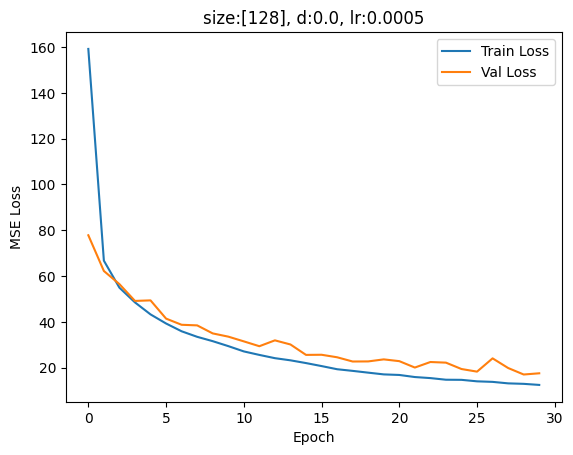

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 149.0861 | Val Loss: 79.7537
Epoch 2/30 | Train Loss: 91.6807 | Val Loss: 67.7363
Epoch 3/30 | Train Loss: 83.7443 | Val Loss: 60.2689
Epoch 4/30 | Train Loss: 79.9216 | Val Loss: 53.6987
Epoch 5/30 | Train Loss: 76.5681 | Val Loss: 50.7599
Epoch 6/30 | Train Loss: 73.5394 | Val Loss: 48.0115
Epoch 7/30 | Train Loss: 71.4314 | Val Loss: 48.2933
Epoch 8/30 | Train Loss: 67.7140 | Val Loss: 46.2112
Epoch 9/30 | Train Loss: 65.2363 | Val Loss: 51.9506
Epoch 10/30 | Train Loss: 65.6105 | Val Loss: 43.7937
Epoch 11/30 | Train Loss: 65.1604 | Val Loss: 43.0519
Epoch 12/30 | Train Loss: 64.7468 | Val Loss: 42.0972
Epoch 13/30 | Train Loss: 61.8622 | Val Loss: 40.4755
Epoch 14/30 | Train Loss: 60.0623 | Val Loss: 41.0964
Epoch 15/30 | Train Loss: 60.4889 | Val Loss: 36.7320
Epoch 16/30 | Train Loss: 60.4752 | Val Loss: 36.9116
Epoch 17/30 | Train Loss: 60.0107 | Val Loss: 38.7879
Epoch 18/30 | Train Loss: 57.0826 | Val Loss: 34.2837
Epoch 19/30 | Train Loss: 55.9950 | 

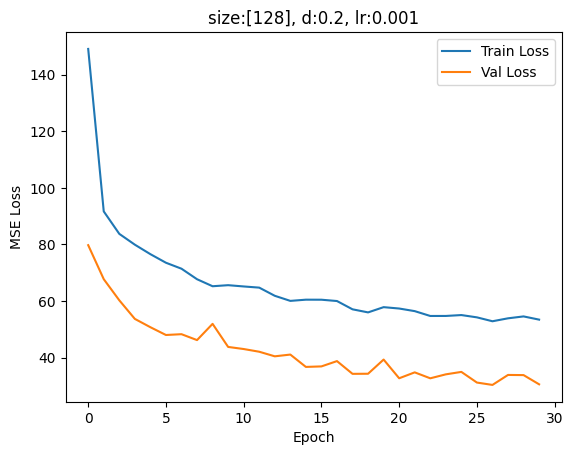

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 180.9045 | Val Loss: 76.0859
Epoch 2/30 | Train Loss: 87.9382 | Val Loss: 63.5477
Epoch 3/30 | Train Loss: 80.3491 | Val Loss: 57.2640
Epoch 4/30 | Train Loss: 75.8256 | Val Loss: 51.8037
Epoch 5/30 | Train Loss: 70.1921 | Val Loss: 52.2927
Epoch 6/30 | Train Loss: 68.7075 | Val Loss: 46.9846
Epoch 7/30 | Train Loss: 65.9060 | Val Loss: 46.7468
Epoch 8/30 | Train Loss: 64.4009 | Val Loss: 47.8296
Epoch 9/30 | Train Loss: 63.0734 | Val Loss: 49.1583
Epoch 10/30 | Train Loss: 60.3108 | Val Loss: 38.5106
Epoch 11/30 | Train Loss: 58.7959 | Val Loss: 37.2718
Epoch 12/30 | Train Loss: 58.3803 | Val Loss: 38.8338
Epoch 13/30 | Train Loss: 56.5737 | Val Loss: 36.9473
Epoch 14/30 | Train Loss: 56.2134 | Val Loss: 36.4499
Epoch 15/30 | Train Loss: 55.6557 | Val Loss: 35.2289
Epoch 16/30 | Train Loss: 54.7588 | Val Loss: 33.1622
Epoch 17/30 | Train Loss: 52.5527 | Val Loss: 32.3275
Epoch 18/30 | Train Loss: 52.6209 | Val Loss: 31.6964
Epoch 19/30 | Train Loss: 52.1633 | 

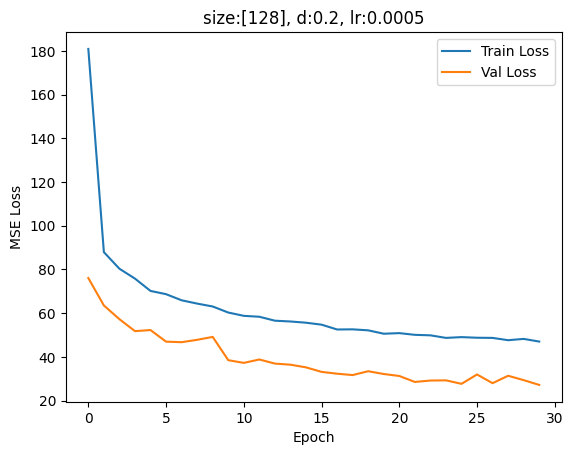

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 160.9601 | Val Loss: 79.1808
Epoch 2/30 | Train Loss: 107.5443 | Val Loss: 67.6636
Epoch 3/30 | Train Loss: 99.3129 | Val Loss: 59.3185
Epoch 4/30 | Train Loss: 95.5484 | Val Loss: 62.7768
Epoch 5/30 | Train Loss: 90.8791 | Val Loss: 53.4474
Epoch 6/30 | Train Loss: 89.6023 | Val Loss: 48.6373
Epoch 7/30 | Train Loss: 86.9919 | Val Loss: 70.5660
Epoch 8/30 | Train Loss: 85.2345 | Val Loss: 46.7925
Epoch 9/30 | Train Loss: 84.6416 | Val Loss: 44.6143
Epoch 10/30 | Train Loss: 83.0131 | Val Loss: 41.8119
Epoch 11/30 | Train Loss: 79.5279 | Val Loss: 43.4433
Epoch 12/30 | Train Loss: 79.2473 | Val Loss: 40.6483
Epoch 13/30 | Train Loss: 79.9668 | Val Loss: 72.7511
Epoch 14/30 | Train Loss: 77.2957 | Val Loss: 38.9643
Epoch 15/30 | Train Loss: 75.2725 | Val Loss: 38.3679
Epoch 16/30 | Train Loss: 74.4119 | Val Loss: 37.8640
Epoch 17/30 | Train Loss: 74.7756 | Val Loss: 36.4124
Epoch 18/30 | Train Loss: 73.7452 | Val Loss: 35.9505
Epoch 19/30 | Train Loss: 71.8333 |

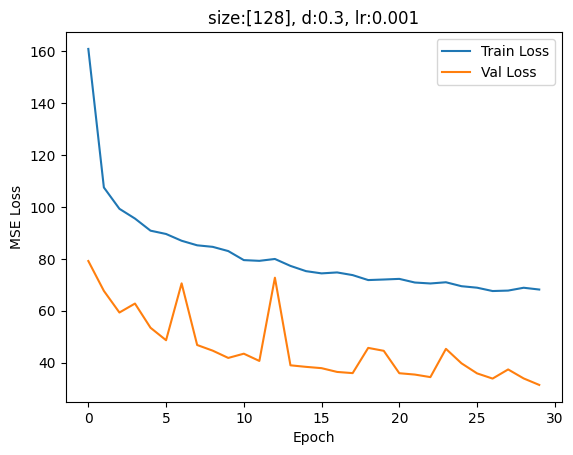

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 213.9856 | Val Loss: 82.3220
Epoch 2/30 | Train Loss: 117.0340 | Val Loss: 77.0444
Epoch 3/30 | Train Loss: 113.2041 | Val Loss: 69.1659
Epoch 4/30 | Train Loss: 105.5819 | Val Loss: 68.1791
Epoch 5/30 | Train Loss: 103.6126 | Val Loss: 71.6851
Epoch 6/30 | Train Loss: 101.4362 | Val Loss: 61.3865
Epoch 7/30 | Train Loss: 98.8813 | Val Loss: 63.9712
Epoch 8/30 | Train Loss: 97.8481 | Val Loss: 61.4568
Epoch 9/30 | Train Loss: 95.0735 | Val Loss: 55.8098
Epoch 10/30 | Train Loss: 94.6462 | Val Loss: 57.2001
Epoch 11/30 | Train Loss: 94.2250 | Val Loss: 53.6336
Epoch 12/30 | Train Loss: 91.8929 | Val Loss: 53.1061
Epoch 13/30 | Train Loss: 92.1535 | Val Loss: 51.5265
Epoch 14/30 | Train Loss: 88.6586 | Val Loss: 49.8331
Epoch 15/30 | Train Loss: 87.7660 | Val Loss: 53.0847
Epoch 16/30 | Train Loss: 87.3409 | Val Loss: 47.7183
Epoch 17/30 | Train Loss: 86.5781 | Val Loss: 47.4539
Epoch 18/30 | Train Loss: 86.2293 | Val Loss: 47.4609
Epoch 19/30 | Train Loss: 85.80

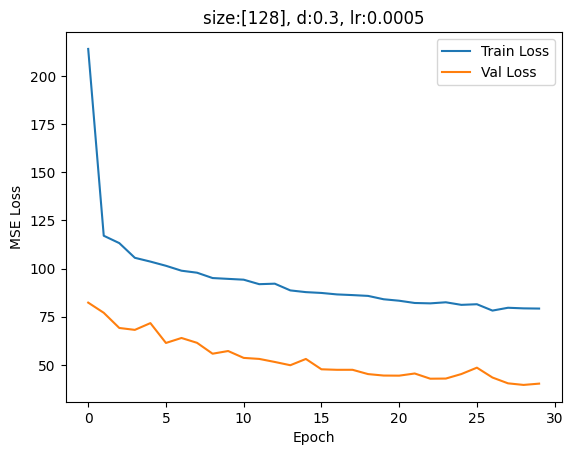

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 106.5019 | Val Loss: 62.4471
Epoch 2/30 | Train Loss: 51.5747 | Val Loss: 43.0661
Epoch 3/30 | Train Loss: 36.7101 | Val Loss: 37.2727
Epoch 4/30 | Train Loss: 28.3242 | Val Loss: 32.3773
Epoch 5/30 | Train Loss: 24.4267 | Val Loss: 30.7313
Epoch 6/30 | Train Loss: 21.0726 | Val Loss: 25.9983
Epoch 7/30 | Train Loss: 18.8450 | Val Loss: 21.0631
Epoch 8/30 | Train Loss: 18.0795 | Val Loss: 31.9658
Epoch 9/30 | Train Loss: 16.1108 | Val Loss: 19.6516
Epoch 10/30 | Train Loss: 15.1971 | Val Loss: 25.5003
Epoch 11/30 | Train Loss: 13.7994 | Val Loss: 17.4102
Epoch 12/30 | Train Loss: 12.9094 | Val Loss: 15.7820
Epoch 13/30 | Train Loss: 12.8137 | Val Loss: 15.4834
Epoch 14/30 | Train Loss: 12.2246 | Val Loss: 16.8715
Epoch 15/30 | Train Loss: 11.9319 | Val Loss: 15.9998
Epoch 16/30 | Train Loss: 11.1556 | Val Loss: 16.1808
Epoch 17/30 | Train Loss: 11.2533 | Val Loss: 15.3667
Epoch 18/30 | Train Loss: 10.1089 | Val Loss: 15.4631
Epoch 19/30 | Train Loss: 10.0657 | 

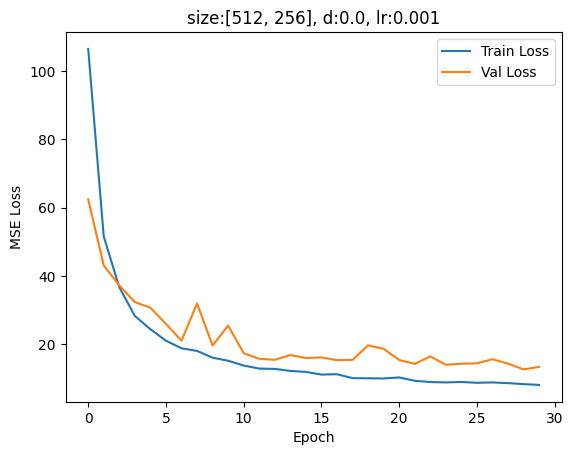

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 125.1904 | Val Loss: 60.8825
Epoch 2/30 | Train Loss: 48.1722 | Val Loss: 43.1138
Epoch 3/30 | Train Loss: 34.8169 | Val Loss: 35.1695
Epoch 4/30 | Train Loss: 27.4268 | Val Loss: 29.6415
Epoch 5/30 | Train Loss: 23.6694 | Val Loss: 25.0165
Epoch 6/30 | Train Loss: 20.4989 | Val Loss: 20.9161
Epoch 7/30 | Train Loss: 18.0173 | Val Loss: 19.2414
Epoch 8/30 | Train Loss: 16.5224 | Val Loss: 25.6951
Epoch 9/30 | Train Loss: 15.2316 | Val Loss: 18.3597
Epoch 10/30 | Train Loss: 14.7575 | Val Loss: 19.5858
Epoch 11/30 | Train Loss: 13.0505 | Val Loss: 16.9426
Epoch 12/30 | Train Loss: 12.7926 | Val Loss: 17.5164
Epoch 13/30 | Train Loss: 12.4860 | Val Loss: 16.3235
Epoch 14/30 | Train Loss: 11.7377 | Val Loss: 17.1330
Epoch 15/30 | Train Loss: 11.1347 | Val Loss: 15.2957
Epoch 16/30 | Train Loss: 11.1324 | Val Loss: 16.6403
Epoch 17/30 | Train Loss: 10.4165 | Val Loss: 15.7078
Epoch 18/30 | Train Loss: 10.3229 | Val Loss: 15.2886
Epoch 19/30 | Train Loss: 10.0601 | 

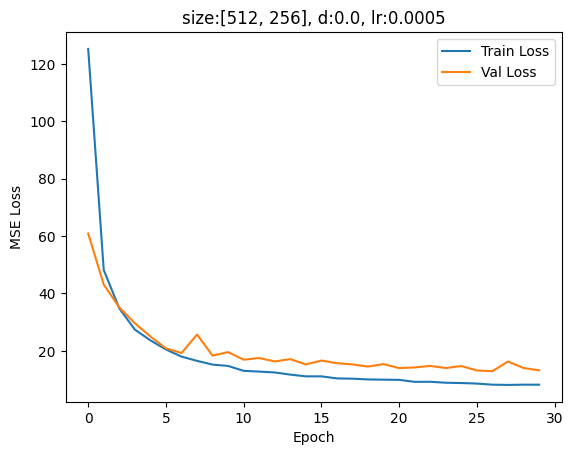

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 138.0900 | Val Loss: 68.1780
Epoch 2/30 | Train Loss: 82.8035 | Val Loss: 52.4459
Epoch 3/30 | Train Loss: 72.7006 | Val Loss: 55.6344
Epoch 4/30 | Train Loss: 69.1883 | Val Loss: 48.8259
Epoch 5/30 | Train Loss: 60.2710 | Val Loss: 36.4497
Epoch 6/30 | Train Loss: 59.1449 | Val Loss: 38.6849
Epoch 7/30 | Train Loss: 57.2767 | Val Loss: 32.3366
Epoch 8/30 | Train Loss: 54.4505 | Val Loss: 32.2856
Epoch 9/30 | Train Loss: 51.5654 | Val Loss: 33.0548
Epoch 10/30 | Train Loss: 51.2904 | Val Loss: 28.8114
Epoch 11/30 | Train Loss: 49.5935 | Val Loss: 31.9468
Epoch 12/30 | Train Loss: 45.9016 | Val Loss: 29.7278
Epoch 13/30 | Train Loss: 47.9857 | Val Loss: 80.6304
Epoch 14/30 | Train Loss: 46.0341 | Val Loss: 28.5064
Epoch 15/30 | Train Loss: 47.1611 | Val Loss: 29.9397
Epoch 16/30 | Train Loss: 45.4061 | Val Loss: 24.6094
Epoch 17/30 | Train Loss: 45.6494 | Val Loss: 27.2243
Epoch 18/30 | Train Loss: 42.2239 | Val Loss: 30.9077
Epoch 19/30 | Train Loss: 44.8596 | 

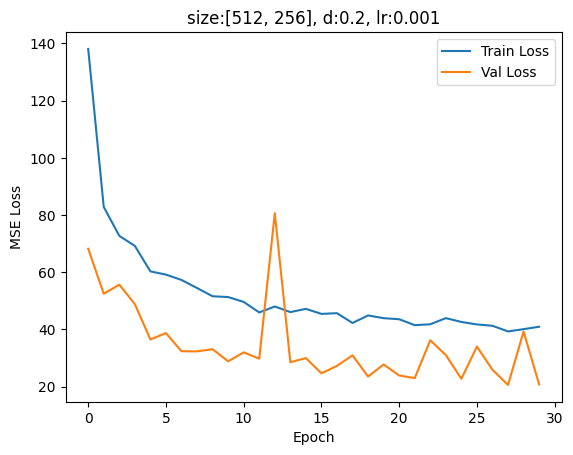

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 141.5164 | Val Loss: 64.2890
Epoch 2/30 | Train Loss: 73.5290 | Val Loss: 49.1996
Epoch 3/30 | Train Loss: 63.7020 | Val Loss: 41.8414
Epoch 4/30 | Train Loss: 56.5138 | Val Loss: 38.2501
Epoch 5/30 | Train Loss: 53.6985 | Val Loss: 37.5382
Epoch 6/30 | Train Loss: 50.2485 | Val Loss: 34.4981
Epoch 7/30 | Train Loss: 47.8927 | Val Loss: 30.7965
Epoch 8/30 | Train Loss: 45.6940 | Val Loss: 36.0153
Epoch 9/30 | Train Loss: 44.2023 | Val Loss: 41.4504
Epoch 10/30 | Train Loss: 42.0696 | Val Loss: 55.4415
Epoch 11/30 | Train Loss: 41.7419 | Val Loss: 28.4385
Epoch 12/30 | Train Loss: 41.2431 | Val Loss: 35.7552
Epoch 13/30 | Train Loss: 40.2283 | Val Loss: 26.0785
Epoch 14/30 | Train Loss: 38.8603 | Val Loss: 24.7240
Epoch 15/30 | Train Loss: 38.1920 | Val Loss: 25.3198
Epoch 16/30 | Train Loss: 37.3995 | Val Loss: 22.2837
Epoch 17/30 | Train Loss: 36.7126 | Val Loss: 23.5892
Epoch 18/30 | Train Loss: 37.2691 | Val Loss: 29.1695
Epoch 19/30 | Train Loss: 35.0455 | 

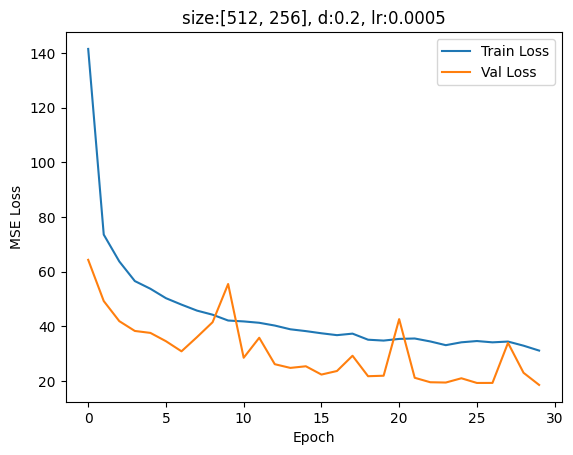

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 157.1250 | Val Loss: 82.1258
Epoch 2/30 | Train Loss: 106.4615 | Val Loss: 68.4519
Epoch 3/30 | Train Loss: 89.9405 | Val Loss: 66.8980
Epoch 4/30 | Train Loss: 86.6786 | Val Loss: 47.7971
Epoch 5/30 | Train Loss: 81.1958 | Val Loss: 44.6421
Epoch 6/30 | Train Loss: 76.4759 | Val Loss: 40.7917
Epoch 7/30 | Train Loss: 75.3945 | Val Loss: 41.7888
Epoch 8/30 | Train Loss: 72.2397 | Val Loss: 36.8161
Epoch 9/30 | Train Loss: 71.5242 | Val Loss: 38.4097
Epoch 10/30 | Train Loss: 68.2135 | Val Loss: 34.0319
Epoch 11/30 | Train Loss: 67.2368 | Val Loss: 44.6382
Epoch 12/30 | Train Loss: 66.5695 | Val Loss: 35.2177
Epoch 13/30 | Train Loss: 67.4497 | Val Loss: 30.8136
Epoch 14/30 | Train Loss: 69.0662 | Val Loss: 49.8861
Epoch 15/30 | Train Loss: 60.4226 | Val Loss: 33.5813
Epoch 16/30 | Train Loss: 63.4607 | Val Loss: 67.7520
Epoch 17/30 | Train Loss: 64.3791 | Val Loss: 28.3834
Epoch 18/30 | Train Loss: 63.9171 | Val Loss: 27.3891
Epoch 19/30 | Train Loss: 60.8120 |

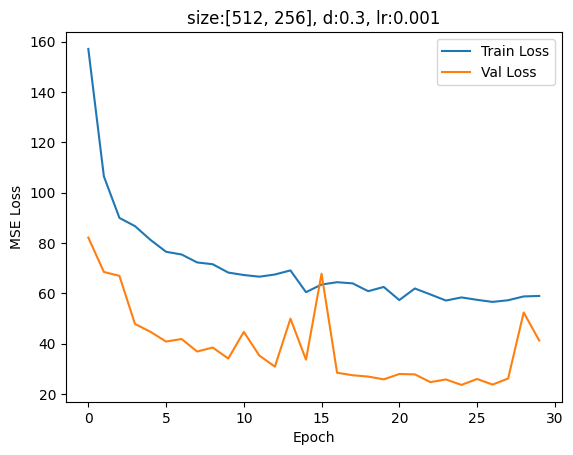

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 160.6000 | Val Loss: 69.7129
Epoch 2/30 | Train Loss: 92.5499 | Val Loss: 57.7060
Epoch 3/30 | Train Loss: 83.4462 | Val Loss: 55.6029
Epoch 4/30 | Train Loss: 76.2893 | Val Loss: 64.1773
Epoch 5/30 | Train Loss: 71.7209 | Val Loss: 46.7246
Epoch 6/30 | Train Loss: 70.1898 | Val Loss: 46.9779
Epoch 7/30 | Train Loss: 66.4302 | Val Loss: 42.5120
Epoch 8/30 | Train Loss: 62.7020 | Val Loss: 37.5217
Epoch 9/30 | Train Loss: 60.1492 | Val Loss: 32.2226
Epoch 10/30 | Train Loss: 60.6424 | Val Loss: 31.2687
Epoch 11/30 | Train Loss: 57.0448 | Val Loss: 30.0437
Epoch 12/30 | Train Loss: 58.0317 | Val Loss: 29.5809
Epoch 13/30 | Train Loss: 55.2379 | Val Loss: 31.9846
Epoch 14/30 | Train Loss: 55.0642 | Val Loss: 30.7777
Epoch 15/30 | Train Loss: 54.7738 | Val Loss: 27.4486
Epoch 16/30 | Train Loss: 54.4064 | Val Loss: 42.6377
Epoch 17/30 | Train Loss: 53.5100 | Val Loss: 41.6073
Epoch 18/30 | Train Loss: 52.4610 | Val Loss: 27.9643
Epoch 19/30 | Train Loss: 51.0101 | 

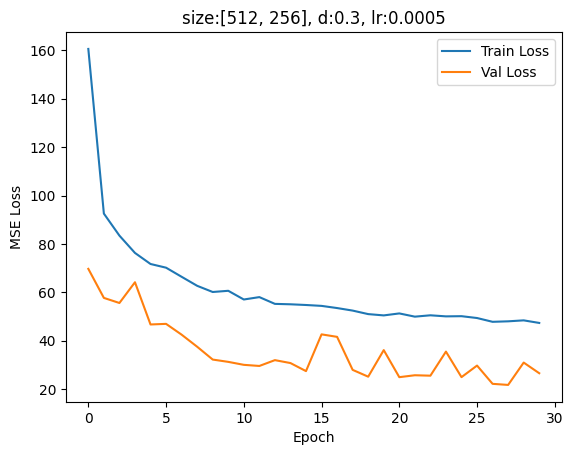

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 108.2323 | Val Loss: 62.5429
Epoch 2/30 | Train Loss: 48.5550 | Val Loss: 37.3322
Epoch 3/30 | Train Loss: 36.1463 | Val Loss: 34.6857
Epoch 4/30 | Train Loss: 30.3886 | Val Loss: 31.9763
Epoch 5/30 | Train Loss: 25.6396 | Val Loss: 25.2792
Epoch 6/30 | Train Loss: 22.1125 | Val Loss: 21.8187
Epoch 7/30 | Train Loss: 19.6798 | Val Loss: 21.5895
Epoch 8/30 | Train Loss: 17.9002 | Val Loss: 22.1068
Epoch 9/30 | Train Loss: 16.5295 | Val Loss: 21.4881
Epoch 10/30 | Train Loss: 15.8650 | Val Loss: 17.1438
Epoch 11/30 | Train Loss: 14.6571 | Val Loss: 19.0108
Epoch 12/30 | Train Loss: 14.1463 | Val Loss: 17.4364
Epoch 13/30 | Train Loss: 12.9881 | Val Loss: 22.5200
Epoch 14/30 | Train Loss: 12.1055 | Val Loss: 15.7775
Epoch 15/30 | Train Loss: 11.7724 | Val Loss: 18.6124
Epoch 16/30 | Train Loss: 12.2299 | Val Loss: 15.2168
Epoch 17/30 | Train Loss: 10.6762 | Val Loss: 15.6732
Epoch 18/30 | Train Loss: 10.8953 | Val Loss: 17.0909
Epoch 19/30 | Train Loss: 10.1883 | 

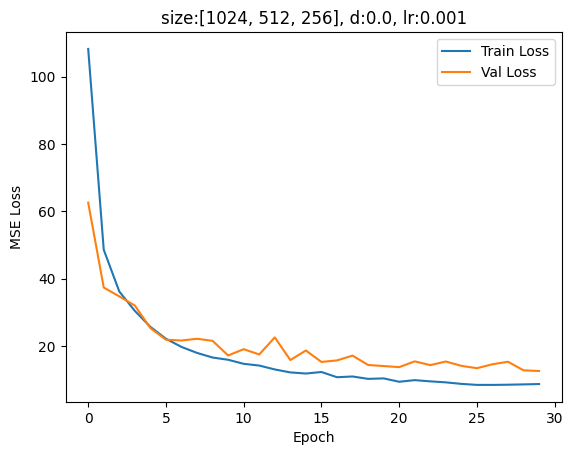

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 120.4073 | Val Loss: 52.7893
Epoch 2/30 | Train Loss: 45.6391 | Val Loss: 41.7676
Epoch 3/30 | Train Loss: 34.8791 | Val Loss: 30.7760
Epoch 4/30 | Train Loss: 27.5615 | Val Loss: 27.9036
Epoch 5/30 | Train Loss: 21.3052 | Val Loss: 25.7114
Epoch 6/30 | Train Loss: 18.3673 | Val Loss: 27.1129
Epoch 7/30 | Train Loss: 17.2389 | Val Loss: 19.9914
Epoch 8/30 | Train Loss: 15.0907 | Val Loss: 21.5593
Epoch 9/30 | Train Loss: 14.2251 | Val Loss: 23.4697
Epoch 10/30 | Train Loss: 13.7025 | Val Loss: 17.6572
Epoch 11/30 | Train Loss: 13.1992 | Val Loss: 16.1995
Epoch 12/30 | Train Loss: 12.2162 | Val Loss: 20.7476
Epoch 13/30 | Train Loss: 11.6071 | Val Loss: 15.4616
Epoch 14/30 | Train Loss: 11.2324 | Val Loss: 14.6624
Epoch 15/30 | Train Loss: 10.6435 | Val Loss: 16.8480
Epoch 16/30 | Train Loss: 10.4680 | Val Loss: 15.4162
Epoch 17/30 | Train Loss: 10.3278 | Val Loss: 14.5749
Epoch 18/30 | Train Loss: 9.4456 | Val Loss: 14.0143
Epoch 19/30 | Train Loss: 9.7326 | Va

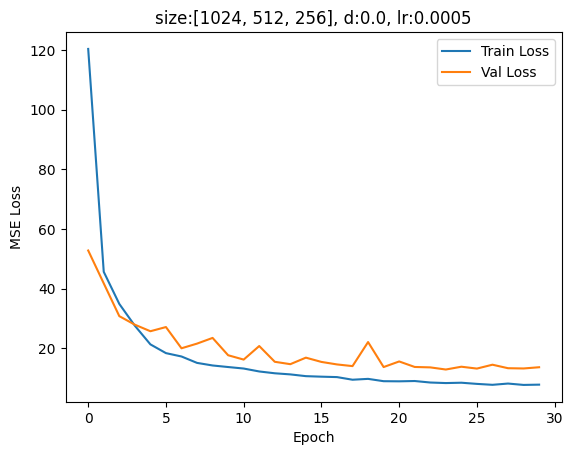

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 142.2887 | Val Loss: 66.2307
Epoch 2/30 | Train Loss: 92.3323 | Val Loss: 54.9180
Epoch 3/30 | Train Loss: 86.1985 | Val Loss: 44.7152
Epoch 4/30 | Train Loss: 80.7101 | Val Loss: 45.6392
Epoch 5/30 | Train Loss: 69.4746 | Val Loss: 46.0149
Epoch 6/30 | Train Loss: 67.2357 | Val Loss: 36.2969
Epoch 7/30 | Train Loss: 66.6974 | Val Loss: 33.8892
Epoch 8/30 | Train Loss: 61.1143 | Val Loss: 49.7825
Epoch 9/30 | Train Loss: 62.2464 | Val Loss: 36.8359
Epoch 10/30 | Train Loss: 61.3062 | Val Loss: 28.0936
Epoch 11/30 | Train Loss: 62.2604 | Val Loss: 51.5388
Epoch 12/30 | Train Loss: 57.1354 | Val Loss: 26.8292
Epoch 13/30 | Train Loss: 58.1677 | Val Loss: 37.3678
Epoch 14/30 | Train Loss: 56.6952 | Val Loss: 50.5197
Epoch 15/30 | Train Loss: 55.7839 | Val Loss: 28.3790
Epoch 16/30 | Train Loss: 52.7641 | Val Loss: 24.7167
Epoch 17/30 | Train Loss: 52.9683 | Val Loss: 28.4384
Epoch 18/30 | Train Loss: 53.7242 | Val Loss: 37.8860
Epoch 19/30 | Train Loss: 52.9905 | 

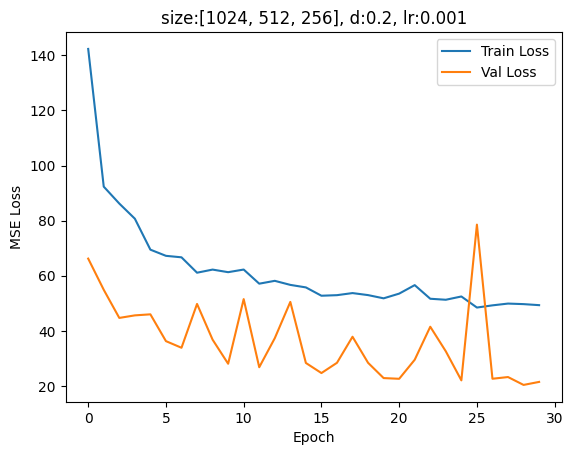

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 149.6309 | Val Loss: 61.1266
Epoch 2/30 | Train Loss: 83.4192 | Val Loss: 47.2926
Epoch 3/30 | Train Loss: 69.8511 | Val Loss: 43.7277
Epoch 4/30 | Train Loss: 65.6125 | Val Loss: 99.3730
Epoch 5/30 | Train Loss: 62.0204 | Val Loss: 59.5081
Epoch 6/30 | Train Loss: 56.4051 | Val Loss: 32.0739
Epoch 7/30 | Train Loss: 55.6060 | Val Loss: 34.7157
Epoch 8/30 | Train Loss: 53.0917 | Val Loss: 29.1177
Epoch 9/30 | Train Loss: 50.6034 | Val Loss: 28.2756
Epoch 10/30 | Train Loss: 47.1403 | Val Loss: 29.4101
Epoch 11/30 | Train Loss: 47.2857 | Val Loss: 33.9823
Epoch 12/30 | Train Loss: 48.0449 | Val Loss: 25.8453
Epoch 13/30 | Train Loss: 46.7402 | Val Loss: 22.8081
Epoch 14/30 | Train Loss: 46.4716 | Val Loss: 23.1563
Epoch 15/30 | Train Loss: 44.0672 | Val Loss: 36.8950
Epoch 16/30 | Train Loss: 47.3621 | Val Loss: 26.6807
Epoch 17/30 | Train Loss: 43.1448 | Val Loss: 25.1755
Epoch 18/30 | Train Loss: 42.3394 | Val Loss: 48.9714
Epoch 19/30 | Train Loss: 43.8970 | 

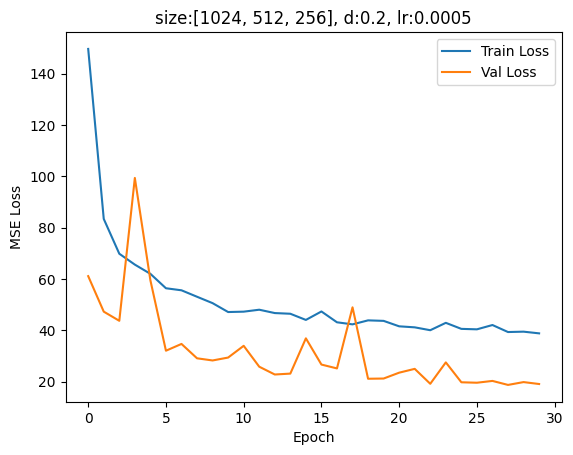

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 168.8102 | Val Loss: 69.6582
Epoch 2/30 | Train Loss: 118.6482 | Val Loss: 75.3155
Epoch 3/30 | Train Loss: 111.4178 | Val Loss: 57.0206
Epoch 4/30 | Train Loss: 96.7058 | Val Loss: 45.2013
Epoch 5/30 | Train Loss: 95.4959 | Val Loss: 53.7020
Epoch 6/30 | Train Loss: 96.5375 | Val Loss: 45.3500
Epoch 7/30 | Train Loss: 92.0841 | Val Loss: 92.3520
Epoch 8/30 | Train Loss: 86.7141 | Val Loss: 41.1381
Epoch 9/30 | Train Loss: 87.2470 | Val Loss: 43.7577
Epoch 10/30 | Train Loss: 84.0513 | Val Loss: 40.7610
Epoch 11/30 | Train Loss: 81.4929 | Val Loss: 77.2987
Epoch 12/30 | Train Loss: 84.2373 | Val Loss: 47.2959
Epoch 13/30 | Train Loss: 81.0462 | Val Loss: 32.1489
Epoch 14/30 | Train Loss: 77.1519 | Val Loss: 32.9671
Epoch 15/30 | Train Loss: 81.0165 | Val Loss: 89.6421
Epoch 16/30 | Train Loss: 77.6529 | Val Loss: 67.0699
Epoch 17/30 | Train Loss: 77.9271 | Val Loss: 27.8515
Epoch 18/30 | Train Loss: 76.8116 | Val Loss: 28.1923
Epoch 19/30 | Train Loss: 75.4189 

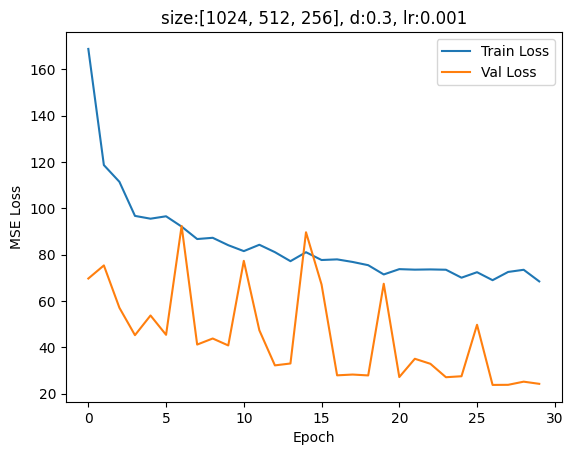

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30 | Train Loss: 168.7443 | Val Loss: 68.4307
Epoch 2/30 | Train Loss: 109.6048 | Val Loss: 75.9001
Epoch 3/30 | Train Loss: 93.2065 | Val Loss: 58.4405
Epoch 4/30 | Train Loss: 83.6739 | Val Loss: 46.9743
Epoch 5/30 | Train Loss: 79.5836 | Val Loss: 43.7616
Epoch 6/30 | Train Loss: 76.9810 | Val Loss: 59.7856
Epoch 7/30 | Train Loss: 77.4886 | Val Loss: 65.5567
Epoch 8/30 | Train Loss: 75.7776 | Val Loss: 31.8923
Epoch 9/30 | Train Loss: 67.4468 | Val Loss: 32.9384
Epoch 10/30 | Train Loss: 69.4284 | Val Loss: 58.5024
Epoch 11/30 | Train Loss: 66.7057 | Val Loss: 34.9289
Epoch 12/30 | Train Loss: 65.4105 | Val Loss: 37.5132
Epoch 13/30 | Train Loss: 65.9139 | Val Loss: 26.5857
Epoch 14/30 | Train Loss: 62.9099 | Val Loss: 27.2768
Epoch 15/30 | Train Loss: 62.7067 | Val Loss: 27.8697
Epoch 16/30 | Train Loss: 61.6229 | Val Loss: 34.6513
Epoch 17/30 | Train Loss: 64.1190 | Val Loss: 24.0593
Epoch 18/30 | Train Loss: 59.4197 | Val Loss: 24.0206
Epoch 19/30 | Train Loss: 62.0497 |

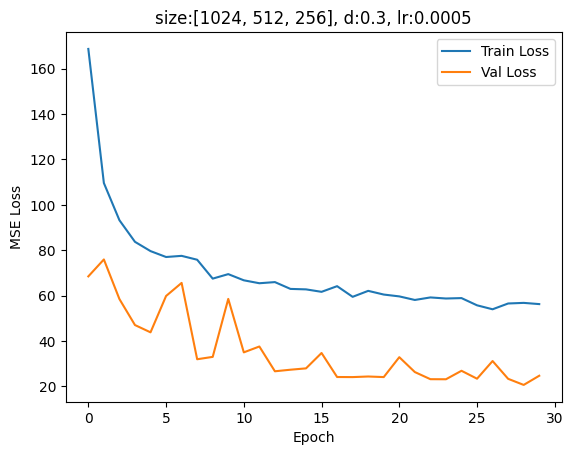

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Best config: {'hidden_sizes': [1024, 512, 256], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.0, 'lr': 0.001, 'epochs': 30} | Final Val Loss: 12.521797305061703


In [23]:
embeddings = np.stack(merged["embedding"].values)
Tm = merged["Tm"].values
input_dim = embeddings.shape[1]

X_train, X_val, y_train, y_val = train_test_split(embeddings, Tm, test_size=0.2, random_state=42)

train_ds = ProteinTmDataset(X_train, y_train)
val_ds = ProteinTmDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


results = []
for i, params in enumerate(hyperparam_sweep):
    train_loss, val_loss = train_and_eval(params, input_dim, train_loader, val_loader)
    results.append((params, train_loss, val_loss))
    plt.figure()
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f'size:{params["hidden_sizes"]}, d:{params["dropout"]}, lr:{params["lr"]}')
    plt.legend()

    fig_filename = f"loss_plot_config{i+1}_9152025.png"
    plt.savefig(fig_filename)
    plt.close()

    files.download(fig_filename)

# Show best
best = sorted(results, key=lambda x: x[2][-1])[0]
print("\nBest config:", best[0], "| Final Val Loss:", best[2][-1])